[![Open In Colab](https://colab.research.google.com/assets/colab-badge.svg)](https://colab.research.google.com/github/NNDesignDeepLearning/NNDesignDeepLearning/blob/master/10.PyTorchIntroChapter/Code/ChapterNotebook/PyTorchIntroChapter.ipynb)

# Objective

This chapter provides an introduction to the **PyTorch** framework for deep learning. At the moment, **TensorFlow** and **PyTorch** are the two most popular frameworks. Over time these two frameworks have become more similar, as they borrow each other's best features. As in Chapter 6, we will show how you can quickly get started to perform all aspects of the typical deep learning workflow: load and preprocess data, build a neural network, train the network and evaluate the results.


# Theory and Examples


The history of PyTorch begins around 2002 with Torch, an open-source machine learning library, scientific computing framework, and scripting language based on Lua. It was originally developed at the Idiap Research Institute at EPFL in Lausanne, Switzerland. The main developers were Ronan Collobert, Samy Bengio and Johnny Mariétho. Torch evolved over multiple revisions through version 7 in 2017.

The front-end for Torch was then converted by Soumith Chintala, Adam Paszke, Sam Gross and Gregory Chanan at Facebook (now Meta) from Lua to Python, at which time it was renamed PyTorch. It is written in Python, C++ and CUDA. PyTorch 2.0 was released on 15 March 2023 and, at the time of this writing, is currently governed by the PyTorch Foundation, a subsidiary of the Linux Foundation.

TensorFlow and PyTorch are very similar, and the deep learning workflow (load and process data, build a neural network, train the network and evaluate the results) is the same. Therefore, this chapter will follow the pattern of Chapter 6, but we will emphasize areas where there are differences between the two frameworks.

## Loading the Data

PyTorch has the same formats for tensors as TensorFlow. Refer to Chapter 6 to review how features, samples, timesteps and channels are indexed in a tensor. PyTorch tensors can be created directly from data, using the `torch.tensor()` command, or from a numpy array, using the `torch.from_numpy()` command.

### XOR 
As in the TensorFlow chapter, we begin by generating data for the XOR problem. For this example we use `torch.tensor()` to create the tensor. We do not need to change the targets using a `to_categorical()` operation, because PyTorch will take care of that when we use the cross entropy loss function.

In [15]:
import numpy as np
import torch

p = torch.tensor([[0, 0], [0, 1], [1, 0], [1, 1]],dtype=torch.float32)
t = torch.tensor([0, 1, 1, 0])
print(p)
print(t)


tensor([[0., 0.],
        [0., 1.],
        [1., 0.],
        [1., 1.]])
tensor([0, 1, 1, 0])


## Constructing the Model

In TensorFlow, the core data structure was the **model**, based on `tensorflow.keras.Model`. The equivalent PyTorch **module** class is based on `torch.nn.Module` The model is a way to organize layers of a network. We will describe two techniques, which have equivalent methods in TensorFlow, to define a model: 1) the sequential class and 2) the module subclass. (In the labs we will consider a third method: using a **pretrained model**.)

For the sequential class, you use the sequential container `torch.nn.Sequential`. Modules are added in the order they are passed to the constructor, as in the following example. Here we create a two-layer network with 10 neurons in the hidden layer and a `tanh` activation function. The network architecture is 2-10-2. (Note that, unlike in Chapter 6, we are not using the softmax activation on the last layer, because it is included in the PyTorch `CrossEntropyLoss`.)

The sequential class is designed for networks where each layer follows the previous one. The `Linear` layer is standard matrix multiplication.

In [16]:
model = torch.nn.Sequential(
    torch.nn.Linear(2, 10),
    torch.nn.Tanh(),
    torch.nn.Linear(10, 2)
)
print(model)

Sequential(
  (0): Linear(in_features=2, out_features=10, bias=True)
  (1): Tanh()
  (2): Linear(in_features=10, out_features=2, bias=True)
)


When you use the **module subclass** method, you create your own fully-customizable models by subclassing the `Model` class and implementing your own forward pass in the `forward` method. The following code implements the same 2-10-2 network using the model subclass method.

In [17]:
class TwoLayer(torch.nn.Module):
    def __init__(self):
        super().__init__()
        self.dense1 = torch.nn.Linear(2, 10)
        self.tanh = torch.nn.Tanh()
        self.dense2 = torch.nn.Linear(10, 2)

    def forward(self, x):
        x = self.dense1(x)
        x = self.tanh(x)
        x = self.dense2(x)
        return x

model = TwoLayer()
print(model)

TwoLayer(
  (dense1): Linear(in_features=2, out_features=10, bias=True)
  (tanh): Tanh()
  (dense2): Linear(in_features=10, out_features=2, bias=True)
)


## Training the Network

After the data has been loaded and the network has been created, the next step is to train the network. In the following we will cover the basic training steps.

Before training a network, we need to select the optimizer to be used. In the following example we use the Adam optimizer. The first argument of the optimizer contains the variables to be adjusted, which are contained in `model.parameters()`. When setting the optimizer, you can also specify optimizer-specific options such as the learning rate, momentum, etc.

In [18]:
optimizer = torch.optim.Adam(model.parameters(), lr=0.001)

We also need to define the loss function. Here we will use the cross entropy loss.

In [19]:
loss_fn = torch.nn.CrossEntropyLoss()

The next step is to train the network. In TensorFlow, we used the `fit` method, but in PyTorch we perform the following steps for each iteration:

1. Zero the gradient
2. Make a forward pass through the network
3. Calculate the loss
4. Compute the gradient
5. Update the weights

The following loop illustrates the process. In this case we pass the entire data set through the network in each iteration. In the labs we will use minibatches. Also, in a difference from TensorFlow, we check to see if a GPU is available, and if so we move the model and the data to the GPU. (If using minibatches, a minibatch would be moved to the GPU at each iteration.) For this simple problem, using the GPU is actually slower than using the cpu.

In [20]:
#Check if a GPU is available, and move model and data
device = 'cuda' if torch.cuda.is_available() else 'cpu'
model.to(device)
p = p.to(device)
t = t.to(device)

epochs = 5000
loss_values = []
for epoch in range(epochs):
    # Zero the gradient
    optimizer.zero_grad()

    # Forward pass through the network
    output = model(p)

    # Calculate the loss
    loss = loss_fn(output, t)

    # Compute the gradient
    loss.backward()

    # Save the loss values for plotting
    loss_values.append(loss.cpu().detach().numpy())

    # Update the weights
    optimizer.step()

We saved the loss values at each iteration, so that we could view the process.

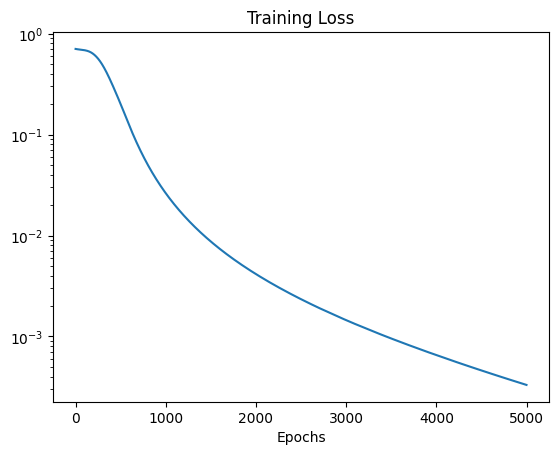

In [21]:
%matplotlib inline
import matplotlib.pyplot as plt
plt.semilogy(range(epochs), loss_values)
plt.title('Training Loss')
plt.xlabel('Epochs')
plt.show()

To calculate the network response for any input you can invoke the model: `model(p)`. Here we apply the training inputs to the model to check the response. (We manually add the `Softmax` function, since it wasn't included in the model. The argument `dim` is the dimension along which the softmax outputs will sum to one.) Is the response correct for the **XOR** problem?

In [22]:
n = model(p)
softmax = torch.nn.Softmax(dim=1)
a = softmax(n)
print(a)

tensor([[9.9973e-01, 2.7249e-04],
        [3.7341e-04, 9.9963e-01],
        [2.4009e-04, 9.9976e-01],
        [9.9956e-01, 4.3846e-04]], device='cuda:0', grad_fn=<SoftmaxBackward0>)


## Advanced Data Loading

As described in the TensrFlow chapter, the ETL process of loading/formatting/pre-processing data is one of the most important parts of the deep learning workflow. The procedures for doing this in PyTorch are very similar to those in TensorFlow.

TensorFlow had the `tf.data.Dataset` API for creating input pipelines. PyTorch has `torch.utils.data.Dataset` and `torch.utils.data.DataLoader`. They enable you to use pre-loaded datasets or your own data. `Dataset` defines what the data are and how to access them, while `DataLoader` defines how to load that data efficiently for model training or inference.

PyTorch `Dataset`:

1. Represents the data and enables access to individual samples
2. Each item of the dataset has an input and a target
3. Defines how to load and preprocess individual data points
4. Implements `__getitem__()` to retrieve a single sample and `__len__()` for the total number of samples
5. Focuses on data representation and access

PyTorch `DataLoader`:

1. Wraps a `Dataset` and provides utilities for batching, shuffling, and parallel data loading
2. Handles the iteration over the dataset, creating batches, and optionally shuffling
3. Allows easy specification of batch size, number of worker processes, etc.
4. Focuses on efficiently feeding data to the model during training/evaluation


To illustrate the operations of `Dataset` and `DataLoader`, we'll work with the CSV file that we used in the Python chapter and lab and the TensorFlow chapter. First, we read in the CSV file into a DataFrame.

In [23]:
import pandas as pd
data_path = '../../../05.PythonChapter/Code/ChapterNotebook/'
sample_df = pd.read_csv(data_path + 'SampleDF.csv')

Next, we extract two columns that we will use as inputs and targets.

In [24]:
P = np.array(sample_df['FVC'])
T = np.array(sample_df['Percent'])

Let's define a `Dataset` class. It should have `__init__()`, `__getitem__()` and `__len__()` methods. The example below is the simplest possible `Dataset`. It loads in the features and targets, it determines the length of the dataset, and it retrieves one item, which consists of a feature and a target. There are many data handling/preprocessing tasks that could also be performed in a `Dataset`: reading data from files, parsing structured data formats (e.g., JSON, XML), normalization, augmentation, etc. We will consider some of these in the labs.

In [25]:
class SimpleDataset(torch.utils.data.Dataset):
    def __init__(self, P, T):
        # convert into PyTorch tensors
        self.P = torch.tensor(P, dtype=torch.float32)
        self.T = torch.tensor(T, dtype=torch.float32)

    def __len__(self):
        # this should return the size of the dataset
        return len(self.P)

    def __getitem__(self, idx):
        # return one input and one target sample from the dataset
        features = self.P[idx]
        target = self.T[idx]
        return features, target

Now we load the data into the `Dataset`.

In [26]:
dataset = SimpleDataset(P, T)

Now that we have the data loaded into the `Dataset`, we can wrap the data in a `DataLoader`. This enables us to control how the data will be fed to the training process (batch size, shuffling).

In [27]:
loader = torch.utils.data.DataLoader(dataset, shuffle=True, batch_size=4)

The `DataLoader` is an iterable, like a data generator, so we can access the elements within the training `for` loop.

In [28]:
for feat, targ in loader:
  print ('Features: {}, Target: {}'.format(feat, targ))
  break

Features: tensor([4029., 2316., 3895., 5768.]), Target: tensor([100.2638,  57.9000,  86.8877, 137.9244])


Here you can see that one minibatch of four inputs and targets has been retrieved, since we set the `batch_size` to 4.

We will investigate other options of `Dataset` and `DataLoader` that allow us to distribute operations across multiple gpus, incorporate augmentation into the data pipeline, prefetch data, etc. in the labs and case studies.

# Epilogue

PyTorch and TensorFlow are currently the most popular deep learning frameworks. They have many similarities, and their performance in terms of computation, training times and memory storage are comparable. They both have strong community support, good documentation and active development. PyTorch has a more intuitive API, and enables faster development and easier debugging. TensorFlow has more deployment options, stronger mobile support and is more established in industry.